In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import random
import json
import csv
import os

# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Y*

**Names:**

* *Kristian Aurlien*
* *Mateusz Paluchowski*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [2]:
import epidemics_helper

In [3]:
# Load raw data from json
with open('../data/nyc_augmented_network.json') as data_file:    
    data = json.load(data_file)

In [98]:
# Create graph from loaded data
from networkx.readwrite import json_graph

G = json_graph.node_link_graph(data)

In [5]:
#Create epidemics SIR simulator
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)

In [6]:
# Launch simulation
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 112.09 days | 112.09 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


In [7]:
# Let's get some info on patient zero:
print('Infection time: ', sir.inf_time[0])
print('Recovery time: ', sir.rec_time[0])

Infection time:  4.51015037512
Recovery time:  9.5591366347


In [8]:
infected = np.asarray([len([x for x in sir.inf_time if x <= i])* 100. / sir.n_nodes for i in range(100)])
recovered = np.asarray([len([x for x in sir.rec_time if x <= i])* 100. / sir.n_nodes for i in range(100)])
susceptible = np.asarray([100 - infected[i] - recovered[i] for i in range(100)])

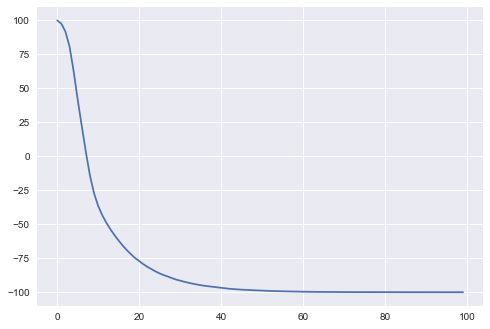

In [9]:
plt.plot(susceptible)
plt.show()

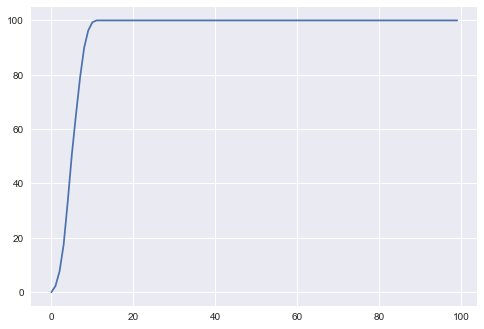

In [10]:
plt.plot(infected)
plt.show()

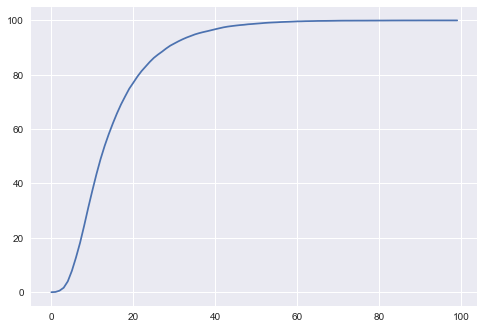

In [11]:
plt.plot(recovered)
plt.show()

In [12]:
def epidemic_evolution(sir):
    days = []
    S_lapse = []
    I_lapse = []
    R_lapse = []
    for day in range(100):
        days.append(day)
        S = 0
        I = 0
        R = 0
        for node in range(sir.n_nodes):
            node_status = sir.get_node_status(node, day)
            if node_status==0:
                S += 1
            elif node_status==1:
                I += 1
            else:
                R +=1
        S_lapse.append(S)
        I_lapse.append(I)
        R_lapse.append(R)
    return S_lapse, I_lapse, R_lapse, days

In [13]:
S_lapse, I_lapse, R_lapse, days = epidemic_evolution(sir)

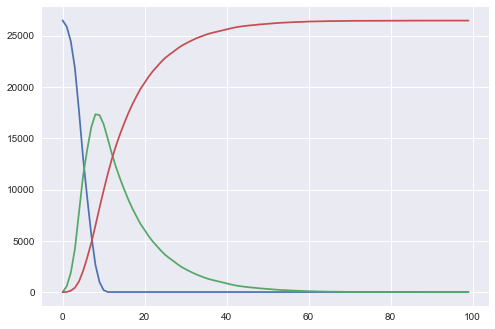

In [14]:
plt.plot(days, S_lapse, days, I_lapse, days, R_lapse)
plt.show()

In [15]:
# How long does it take before 60% of the population is infected?
[ n for n,i in enumerate(I_lapse) if i>0.6*sir.n_nodes ][0]

7

In [16]:
coords = [ [node['coordinates'][1]/1e6, node['coordinates'][0]/1e6] for node in data['nodes']]

In [17]:
# import folium

# mapit = folium.Map( location=[40.706271, -73.887001], zoom_start=6 )
# for coord in coords:
#     folium.Marker( location=[ coord[0], coord[1] ]).add_to( mapit )
# mapit

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [18]:
G1 = G.copy()

In [29]:
def drop_random_edges(graph, no_of_edges):
    G = graph.copy()
    edges = G.edges()
    random.shuffle(edges)
    to_delete = edges[:no_of_edges]

    for edge in to_delete:
        G.remove_edge(*edge)
    return G

In [30]:
G1 = drop_random_edges(G, 1000)

In [46]:
def multi_simulate(G1, number_of_simulations):
    sir = epidemics_helper.SimulationSIR(G1, beta=10.0, gamma=0.1)
    S_agg = np.zeros(100)
    I_agg = np.zeros(100)
    R_agg = np.zeros(100)
    for i in range(number_of_simulations):
        print('Simulation no: ', i)
        rand_source = random.randint(0, G1.number_of_nodes())
        sir.launch_epidemic(source=rand_source, max_time=100.0)
        S_lapse, I_lapse, R_lapse, days = epidemic_evolution(sir)

        S_agg += np.array(S_lapse)
        I_agg += np.array(I_lapse)
        R_agg += np.array(R_lapse)

    S_agg /= 10
    I_agg /= 10
    R_agg /= 10
    
    return S_agg, I_agg, R_agg, days

In [47]:
# Simulate 10 times
S_agg, I_agg, R_agg, days = multi_simulate(G1 , 10)

Simulation no:  0
Epidemic stopped after 115.94 days | 115.94 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  1
Epidemic stopped after 103.02 days | 103.02 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  2
Epidemic stopped after 100.41 days | 100.41 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  3
Epidemic stopped after 113.62 days | 113.62 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  4
Epidemic stopped after 100.10 days | 100.10 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  5
Epidemic stopped after 104.42 days | 104.42 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  6
Epidemic stopped after 102.14 days | 102.14 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Simulation no:  7
Epidemic stopped after 100.18 days | 100.18 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% re

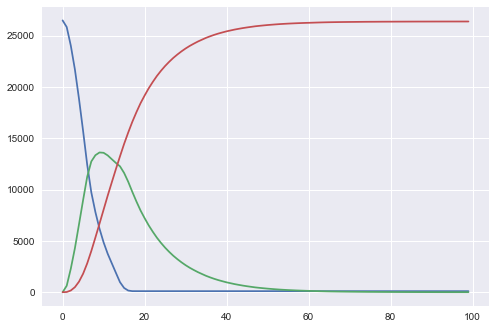

In [48]:
plt.plot(days, S_agg, days, I_agg, days, R_agg)
plt.show()

In [45]:
# On average, how many people are healthy, infected, dead after 30 days?
print('Healthy: ',S_agg[29])
print('Infected: ',I_agg[29])
print('Dead: ',R_agg[29])

Healthy:  98.6
Infected:  3146.9
Dead:  23235.5


#### What happens if you increase the budget (e.g. to 10000 edges)?

In [49]:
G1 = drop_random_edges(G, 10000)

In [50]:
# Simulate 10 times
S_agg, I_agg, R_agg, days = multi_simulate(G1 , 10)

Simulation no:  0
Epidemic stopped after 95.47 days | 95.47 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  1
Epidemic stopped after 103.08 days | 103.08 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  2
Epidemic stopped after 103.76 days | 103.76 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  3
Epidemic stopped after 113.18 days | 113.18 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  4
Epidemic stopped after 117.76 days | 117.76 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  5
Epidemic stopped after 101.28 days | 101.28 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  6
Epidemic stopped after 101.55 days | 101.55 days elapsed | 0.4% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  7
Epidemic stopped after 123.42 days | 123.42 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% reco

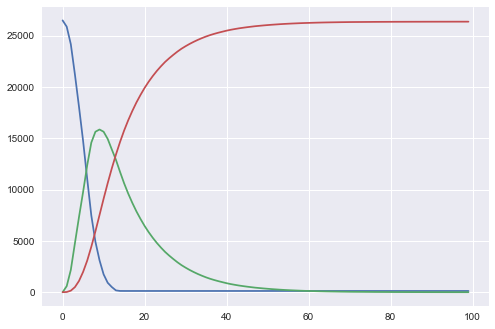

In [51]:
plt.plot(days, S_agg, days, I_agg, days, R_agg)
plt.show()

In [52]:
# On average, how many people are healthy, infected, dead after 30 days?
print('Healthy: ',S_agg[29])
print('Infected: ',I_agg[29])
print('Dead: ',R_agg[29])

Healthy:  121.0
Infected:  2637.2
Dead:  23722.8


In [53]:
G.number_of_edges()

43437

#### Exercise 2.11: Strategy 2

In [62]:
def clever_edge_drop(graph, no_of_edges):
    G = graph.copy()
    edges = G.edges()
    random.shuffle(edges)
    rand_edges = edges[:no_of_edges]
    
    for edge in rand_edges:
        node1, node2  = edge
        if nx.degree(G, node1) > nx.degree(G, node2):
            popular_edges = G.edges(node1)
        else:
            popular_edges = G.edges(node2)
        random.shuffle(popular_edges)
        G.remove_edge(*popular_edges[0])
    return G

In [63]:
G2 = clever_edge_drop(G, 2500)

In [64]:
# Simulate 10 times
S_agg, I_agg, R_agg, days = multi_simulate(G2 , 10)

Simulation no:  0
Epidemic stopped after 100.08 days | 100.08 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  1
Epidemic stopped after 96.66 days | 96.66 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  2
Epidemic stopped after 102.24 days | 102.24 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  3
Epidemic stopped after 100.33 days | 100.33 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Simulation no:  4
Epidemic stopped after 101.24 days | 101.24 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  5
Epidemic stopped after 100.46 days | 100.46 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Simulation no:  6
Epidemic stopped after 101.09 days | 101.09 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Simulation no:  7
Epidemic stopped after 106.78 days | 106.78 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% reco

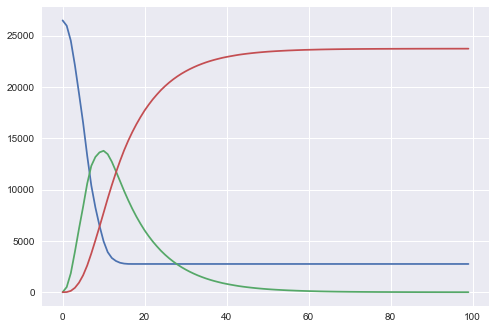

In [65]:
plt.plot(days, S_agg, days, I_agg, days, R_agg)
plt.show()

In [70]:
from operator import itemgetter

def isolate_known_people(graph, no_of_edges):
    G = graph.copy()
    known_people = sorted(G.degree_iter(),key=itemgetter(1),reverse=True)
    
    i = 0
    for people in known_people:
        i += people[1]
        to_remove = G.edges(people[0])
        G.remove_edges_from(to_remove)
        
        if i>= no_of_edges:
            break
    return G

In [74]:
G3 = isolate_known_people(G, 2500)

In [75]:
S_agg, I_agg, R_agg, days = multi_simulate(G3 , 10)

Simulation no:  0
Epidemic stopped after 117.45 days | 117.45 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  1
Epidemic stopped after 106.60 days | 106.60 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  2
Epidemic stopped after 107.64 days | 107.64 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  3
Epidemic stopped after 111.53 days | 111.53 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recovered
Simulation no:  4
Epidemic stopped after 8.08 days | 8.08 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
Simulation no:  5
Epidemic stopped after 104.85 days | 104.85 days elapsed | 2.2% susceptible, 0.0% infected, 97.7% recovered
Simulation no:  6
Epidemic stopped after 107.63 days | 107.63 days elapsed | 2.5% susceptible, 0.0% infected, 97.5% recovered
Simulation no:  7
Epidemic stopped after 113.41 days | 113.41 days elapsed | 2.4% susceptible, 0.0% infected, 97.6% recov

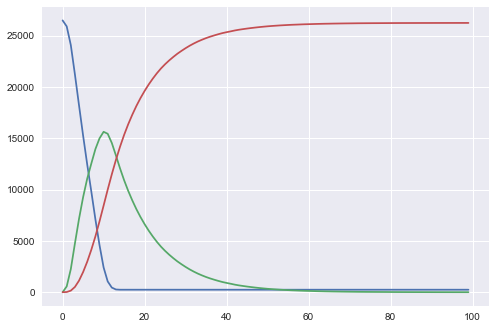

In [73]:
plt.plot(days, S_agg, days, I_agg, days, R_agg)
plt.show()

In [78]:
rand_source = random.randint(0, G.number_of_nodes())
rand_finish = random.randint(0, G.number_of_nodes())

graphs = list(nx.connected_component_subgraphs(G))

In [82]:
nx.number_connected_components(G)


1

In [83]:
articulation_nodes = list(nx.articulation_points(G))

In [99]:
G4 = G.copy()

In [100]:
i = 0
for node in articulation_nodes:
    to_remove = G4.edges(node)
    i += len(to_remove)
    G4.remove_edges_from(to_remove)

In [101]:
i

4959

In [89]:
S_agg, I_agg, R_agg, days = multi_simulate(G4, 10)

Simulation no:  0
Epidemic stopped after 104.48 days | 104.48 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  1
Epidemic stopped after 91.32 days | 91.32 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  2
Epidemic stopped after 102.65 days | 102.65 days elapsed | 86.3% susceptible, 0.0% infected, 13.7% recovered
Simulation no:  3
Epidemic stopped after 110.01 days | 110.01 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  4
Epidemic stopped after 88.97 days | 88.97 days elapsed | 86.1% susceptible, 0.0% infected, 13.9% recovered
Simulation no:  5
Epidemic stopped after 113.70 days | 113.70 days elapsed | 26.9% susceptible, 0.0% infected, 73.1% recovered
Simulation no:  6
Epidemic stopped after 100.19 days | 100.19 days elapsed | 26.8% susceptible, 0.0% infected, 73.2% recovered
Simulation no:  7
Epidemic stopped after 30.24 days | 30.24 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% 

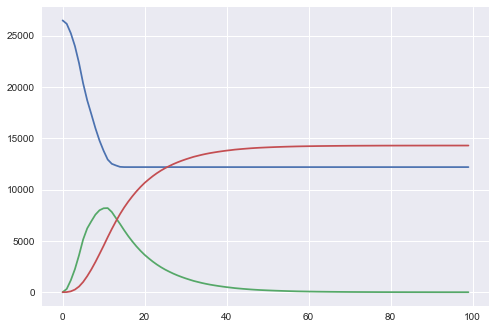

In [90]:
plt.plot(days, S_agg, days, I_agg, days, R_agg)
plt.show()

In [91]:
# On average, how many people are healthy, infected, dead after 30 days?
print('Healthy: ',S_agg[29])
print('Infected: ',I_agg[29])
print('Dead: ',R_agg[29])

Healthy:  12189.4
Infected:  1489.1
Dead:  12802.5


In [ ]:
def separate_components(graph, no_of_edges):
    G = graph.copy()

In [ ]:
# get nodes with high degree and find minimum_edge_cut between them 
# https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.connectivity.cuts.minimum_edge_cut.html
# and disconnect them.